In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
from sklearn.utils import class_weight, shuffle

from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
foldernames = os.listdir('C:/Users/Anup0/Data Science/Animal Detector/raw-img')


In [3]:
base_path = 'C:/Users/Anup0/Data Science/Animal Detector/raw-img/'

foldernames = os.listdir(base_path)

In [4]:
categories = []
files = []

for k, folder in enumerate(foldernames):
    folder_path = os.path.join(base_path, folder)
    filenames = os.listdir(folder_path)
    for file in filenames:
        files.append(os.path.join(folder_path, file))
        categories.append(k)



In [5]:
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

In [6]:
print("Sample file paths from df:")
print(df.filename.head())

Sample file paths from df:
0    C:/Users/Anup0/Data Science/Animal Detector/ra...
1    C:/Users/Anup0/Data Science/Animal Detector/ra...
2    C:/Users/Anup0/Data Science/Animal Detector/ra...
3    C:/Users/Anup0/Data Science/Animal Detector/ra...
4    C:/Users/Anup0/Data Science/Animal Detector/ra...
Name: filename, dtype: object


In [7]:
train_df = pd.DataFrame(columns=['filename', 'category'])


In [8]:

for i in range(10):
    train_df = pd.concat([train_df, df[df.category == i].iloc[:500, :]])

train_df = train_df.reset_index(drop=True)
train_df.head()

train_df

filename category
0     C:/Users/Anup0/Data Science/Animal Detector/ra...        0
1     C:/Users/Anup0/Data Science/Animal Detector/ra...        0
2     C:/Users/Anup0/Data Science/Animal Detector/ra...        0
3     C:/Users/Anup0/Data Science/Animal Detector/ra...        0
4     C:/Users/Anup0/Data Science/Animal Detector/ra...        0
...                                                 ...      ...
4995  C:/Users/Anup0/Data Science/Animal Detector/ra...        9
4996  C:/Users/Anup0/Data Science/Animal Detector/ra...        9
4997  C:/Users/Anup0/Data Science/Animal Detector/ra...        9
4998  C:/Users/Anup0/Data Science/Animal Detector/ra...        9
4999  C:/Users/Anup0/Data Science/Animal Detector/ra...        9

[5000 rows x 2 columns]

In [9]:
y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

In [10]:
print("Sample file paths from train_df:")
print(train_df.filename.head())

Sample file paths from train_df:
0    C:/Users/Anup0/Data Science/Animal Detector/ra...
1    C:/Users/Anup0/Data Science/Animal Detector/ra...
2    C:/Users/Anup0/Data Science/Animal Detector/ra...
3    C:/Users/Anup0/Data Science/Animal Detector/ra...
4    C:/Users/Anup0/Data Science/Animal Detector/ra...
Name: filename, dtype: object


In [11]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [13]:
images = []
failed_images = []

with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        # Check if the file exists
        if not os.path.exists(file_path):
            print(f"File does not exist: {file_path}")
            failed_images.append(file_path)
            pbar.update(1)
            continue
        
        # Read image
        img = cv2.imread(file_path)
        if img is not None:
            try:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize
                if img.shape[0] > img.shape[1]:
                    tile_size = (int(img.shape[1] * 256 / img.shape[0]), 256)
                else:
                    tile_size = (256, int(img.shape[0] * 256 / img.shape[1]))

                # Centering
                img = centering_image(cv2.resize(img, dsize=tile_size))

                # Output 224x224px
                img = img[16:240, 16:240]
                images.append(img)
            except Exception as e:
                print(f"Error processing image {file_path}: {e}")
                failed_images.append(file_path)
        else:
            print(f"Failed to read image: {file_path}")
            failed_images.append(file_path)
        
        pbar.update(1)

print(f"Number of successfully processed images: {len(images)}")
print(f"Number of failed images: {len(failed_images)}")


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 350.25it/s]

Number of successfully processed images: 5000
Number of failed images: 0


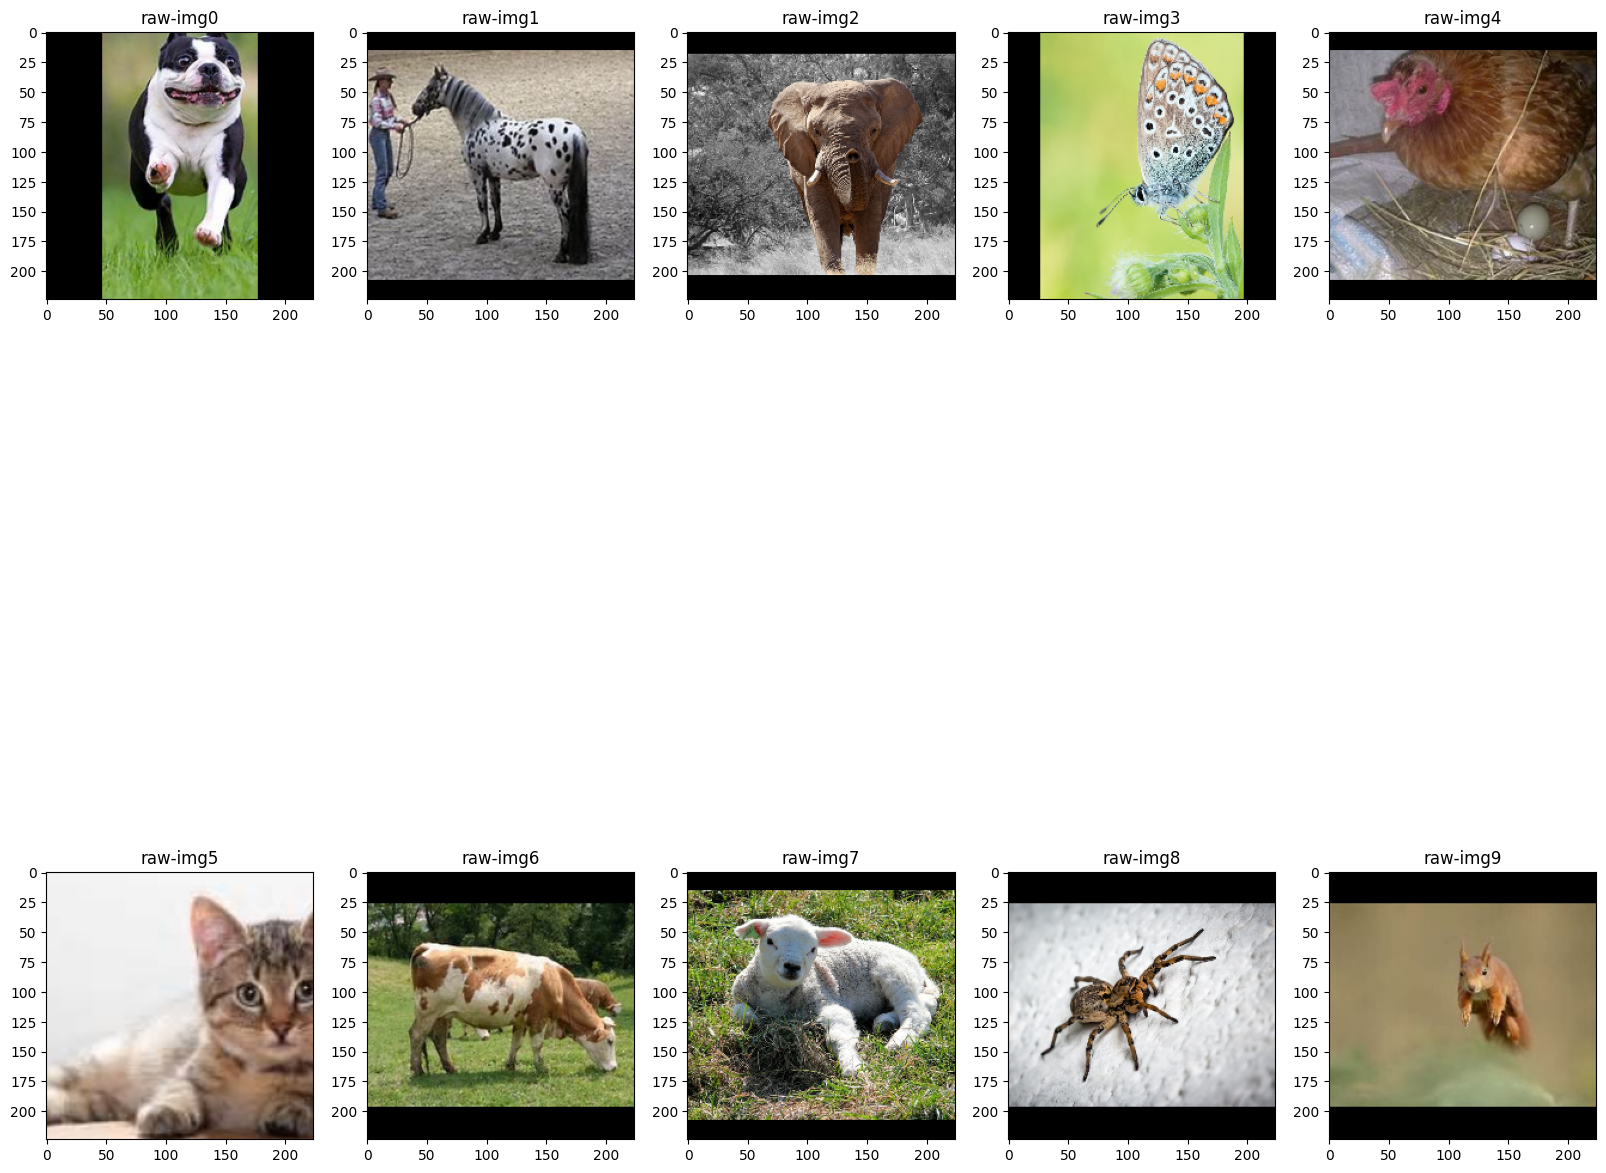

In [14]:
rows,cols = 2,5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [15]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3


x_train (4000, 224, 224, 3)
y_train (4000,)
x_test (1000, 224, 224, 3)
y_test (1000,)


In [16]:
name_animal = []

for i in range(10):
    filtered_df = train_df[train_df.category == i]
    
    if len(filtered_df) > 2:
        path = filtered_df.iloc[2] 
        
        if isinstance(path['filename'], str):
            image_path = path['filename']
            
            image_path = image_path.replace('\\', '/')
            
            animal_folder = image_path.split('/')[-2]
            
            if animal_folder == 'scoiattolo':
                name_animal.append('squirrel')
            elif animal_folder == 'cavallo':
                name_animal.append('horse')
            elif animal_folder == 'farfalla':
                name_animal.append('butterfly')
            elif animal_folder == 'mucca':
                name_animal.append('cow')
            elif animal_folder == 'gatto':
                name_animal.append('cat')
            elif animal_folder == 'pecora':
                name_animal.append('sheep')
            elif animal_folder == 'gallina':
                name_animal.append('chicken')
            elif animal_folder == 'elefante':
                name_animal.append('elephant')
            elif animal_folder == 'ragno':
                name_animal.append('spider')
            elif animal_folder == 'cane':
                name_animal.append('dog')
                
print("Final name_animal list:", name_animal)


Final name_animal list: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


In [17]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Flatten()(base_model.output)
add_model = Dense(512, activation='relu')(add_model)
add_model = Dense(10, activation='softmax')(add_model)

model = Model(inputs=base_model.input, outputs=add_model)

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9), 
    metrics=['accuracy']
)


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,565,386 (105.15 MB)

 Trainable params: 27,565,386 (105.15 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
batch_size = 32
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    
    callbacks=[ModelCheckpoint('Animal_Detector.keras', monitor='val_accuracy')]
)

Epoch 1/50


C:\Users\Anup0\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 1971s 16s/step - accuracy: 0.0996 - loss: 0.4224 - val_accuracy: 0.1680 - val_loss: 0.3219
Epoch 2/50


C:\Users\Anup0\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 857ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1680 - val_loss: 0.3219
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1963s 16s/step - accuracy: 0.2020 - loss: 0.3169 - val_accuracy: 0.2320 - val_loss: 0.3108
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 822ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2320 - val_loss: 0.3108
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1912s 15s/step - accuracy: 0.2849 - loss: 0.3057 - val_accuracy: 0.3320 - val_loss: 0.2969
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 828ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3320 - val_loss: 0.2969
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2046s 16s/step - accuracy: 0.3342 - loss: 0.2929 - val_accuracy: 0.4240 - val_loss: 0.2781
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 907ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4240 - val_loss: 0.2781
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2837s 23s/step - a

CNN: Epochs=50, Train accuracy=0.00000, Validation accuracy=0.83700


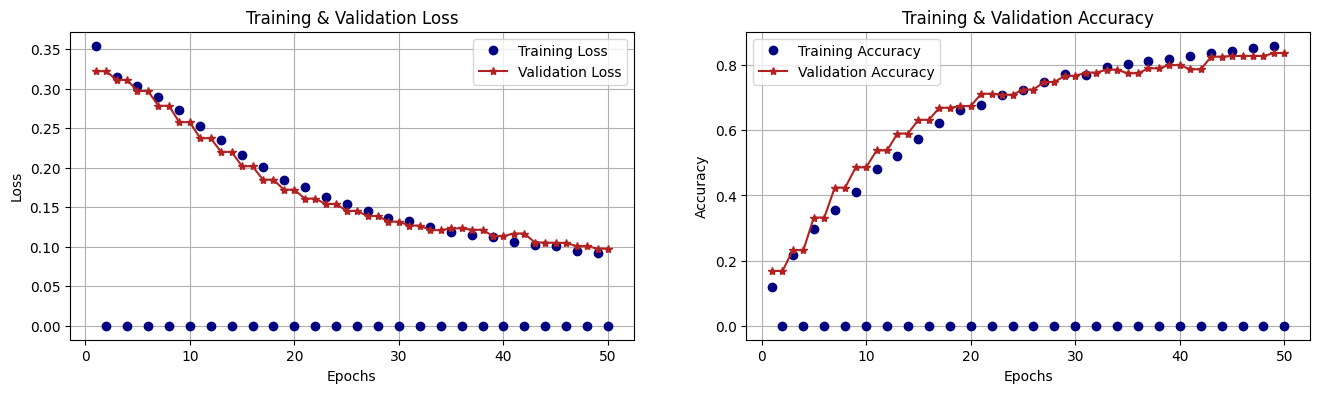

In [19]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))
def show_plots(history):
    
    
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


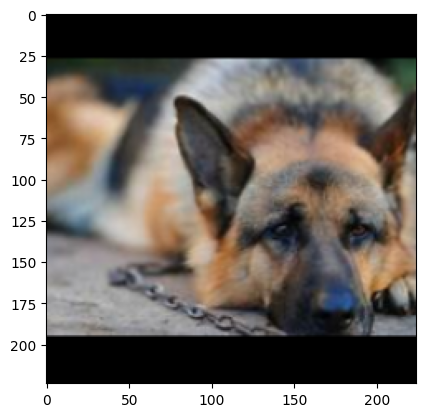

Actual  : dog
Predict : dog


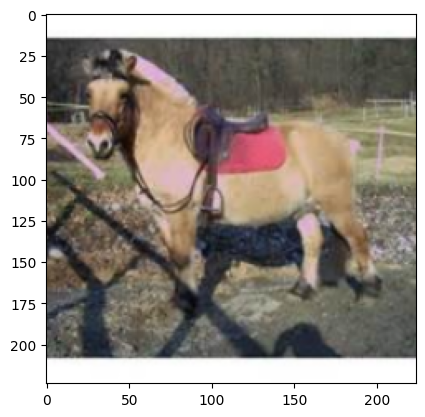

Actual  : horse
Predict : cow


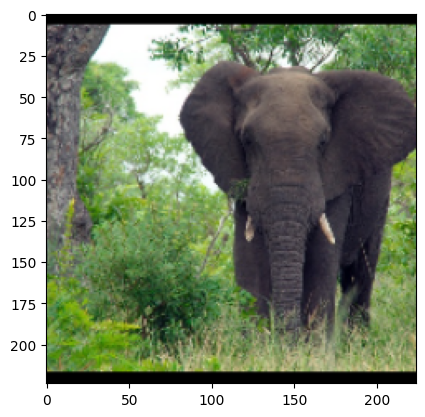

Actual  : elephant
Predict : dog


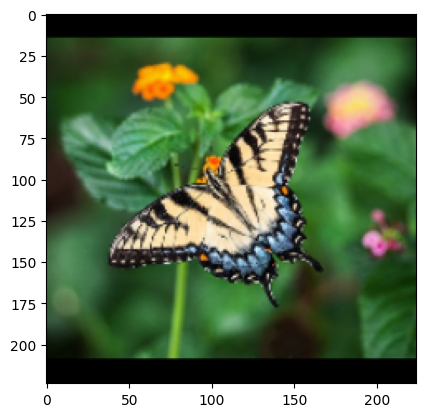

Actual  : butterfly
Predict : butterfly


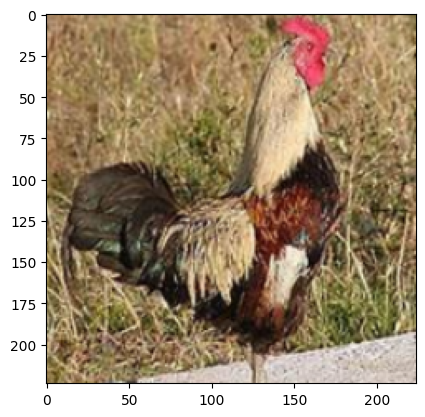

Actual  : chicken
Predict : chicken


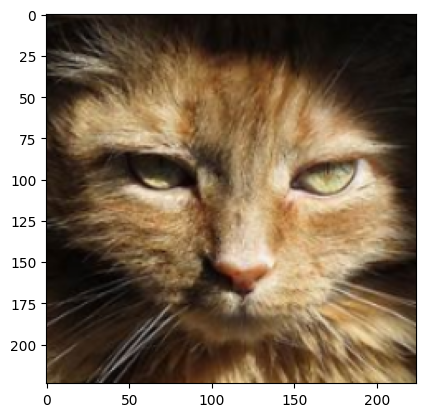

Actual  : cat
Predict : cat


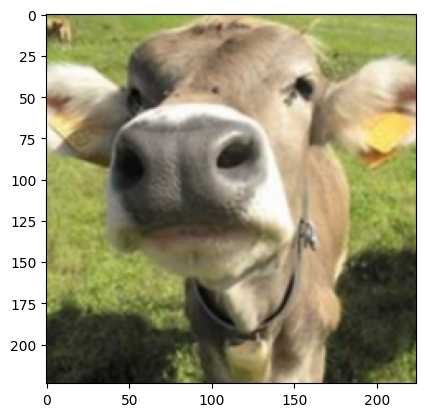

Actual  : cow
Predict : cow


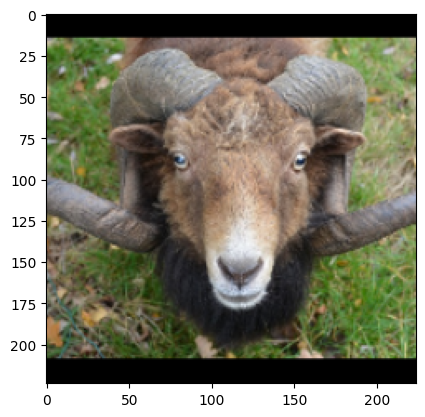

Actual  : sheep
Predict : sheep


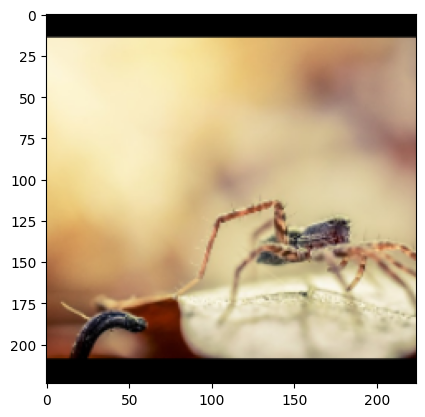

Actual  : spider
Predict : spider


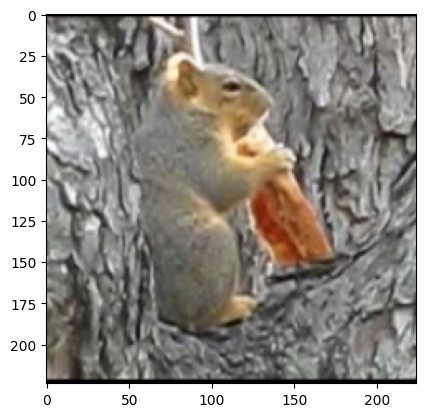

Actual  : squirrel
Predict : squirrel


In [20]:
test_images = []
j = 39 
for i in range(10):
    path = train_df[train_df.category == i].values[j]
    a = images[train_df[train_df.filename == path[0]].index[0]]
    img = np.array(a)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)
something = model.predict(test_images)
animals = name_animal
i = 0
for pred in something:
    path = train_df[train_df.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1